In [1]:
import numpy as np
import pandas as pd

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials

In [2]:
df, price_series, timestamps = load_price_data(
    csv_path   = "../data/raw/dayahead_2024_11.csv",
    resolution = "15min",
)

df_week = df.loc["2024-11-01":"2024-11-07"]   # 672 steps (1 week)
price_week = df_week["Day Ahead Auktion"].values.astype(np.float32)
timestamps_week = df_week.index

In [4]:
# Create BatteryEnv with 15-minute time step (continuous actions for TD3)
env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,               # 15 min
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,  # continuous for TD3
    random_seed=42,
)

# Wrap with Monitor so SB3 can track episode rewards/lengths
train_env = Monitor(env)

# Action noise for TD3 (needed for exploration)
n_actions = train_env.action_space.shape[-1]   # should be 1
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.1 * np.ones(n_actions),            # exploration strength
)

model = TD3(
    "MlpPolicy",
    train_env,
    action_noise=action_noise,
    learning_rate=1e-3,
    buffer_size=100_000,
    learning_starts=1_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    policy_delay=2,
    verbose=1,
)

model.learn(
    total_timesteps=10_000,
    log_interval=10,
    progress_bar=True,
)

print("TD3 training completed.")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 9,992/10,000  [ 0:02:35 < 0:00:01 , 58 it/s ]

TD3 training completed.


In [5]:
# Fresh eval env (same config, different seed)
eval_env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,   # continuous
    random_seed=123,              # different seed for initial SoC
)

obs, info = eval_env.reset()

soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_list_kW = []

revenue_list = []
deg_cost_list = []
penalty_list = []

n_steps = len(price_week)   # one full week (672 steps)

for t in range(n_steps):
    # TD3 is deterministic → use deterministic=True for evaluation
    action, _ = model.predict(obs, deterministic=True)   # action shape: (1,)

    obs, reward, terminated, truncated, info = eval_env.step(action)

    # Store trajectories
    soc_list.append(obs[0])                      # SoC
    soh_list.append(obs[1])                      # SoH
    reward_list.append(reward)
    price_true_list.append(info["price_true"])

    # Continuous action is already kW
    action_list_kW.append(float(action[0]))

    # Financial components
    revenue_list.append(info["revenue_eur"])
    deg_cost_list.append(info["deg_cost_eur"])
    penalty_list.append(info["penalty_eur"])

    if terminated or truncated:
        print(f"Episode finished early at step {t}")
        break


Episode finished early at step 671


=== Financial Summary ===
Total revenue    (EUR): 8.222
Degradation cost (EUR): 2.287
Penalty cost     (EUR): 0.000
Net profit       (EUR): 5.935


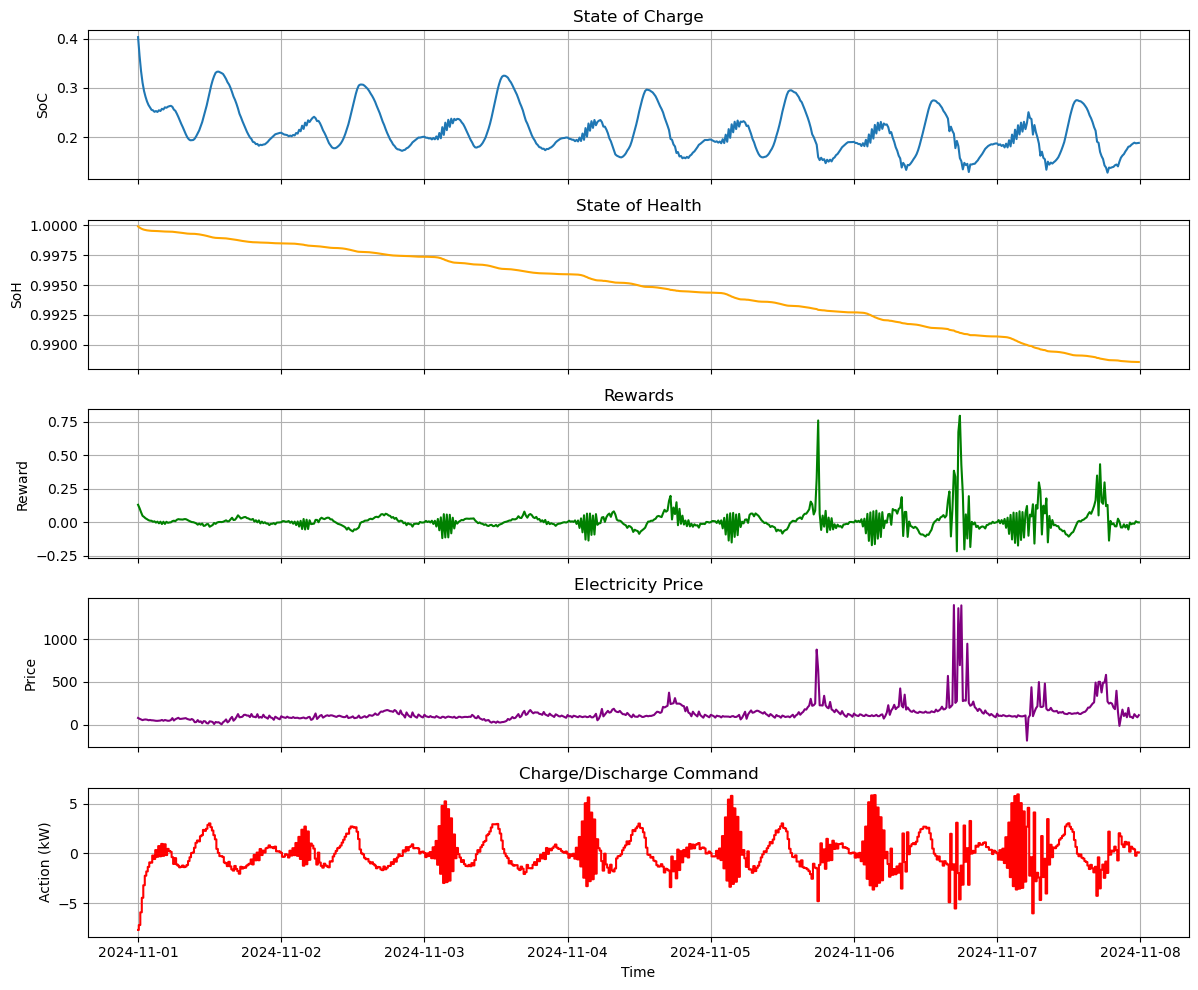

In [6]:
results = evaluate_financials(
    revenue_list,
    deg_cost_list,
    penalty_list,
)

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_list_kW,
    timestamps=timestamps_week[:len(soc_list)],
)